## INFOSYS 722 Assignement Iteration 4 - Sub-iteration 2

In [2]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')

In [3]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math

In [4]:
spark = SparkSession.builder.appName('infosys722-i4-i2').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/11 18:59:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
integrated_purchase_detail = spark.read.options(compression='gzip').format('parquet').load(
    './Ready Datasets/purchase_detail_v001')
integrated_sales = spark.read.options(compression='gzip').format('parquet').load(
    './Ready Datasets/sales_v001')

In [5]:
def remove_extreme_by_z_scores(dataframe, column, threshold = 1):
    mean, std = dataframe.agg(F.mean(column), F.stddev(column)).collect()[0]
    dataframe = dataframe.withColumn('z_scores', (F.col(column) - mean) / std)
    return dataframe.where(F.col('z_scores') <= threshold).drop('z_scores')

integrated_sales = remove_extreme_by_z_scores(integrated_sales, 'SalesQuantity')
integrated_sales.describe('SalesQuantity').show()

+-------+------------------+
|summary|     SalesQuantity|
+-------+------------------+
|  count|             36962|
|   mean|1.9354201612466857|
| stddev|1.4654083220779113|
|    min|                 1|
|    max|                 8|
+-------+------------------+



## Modeling

In [6]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor, LinearRegression, RandomForestRegressor
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, NaiveBayes, GBTClassifier
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

In [7]:
def evaluate_regression_model(result, labelCol, predictionCol='prediction', metrics = ['rmse', 'mse', 'mae', 'r2']):
    results = [(metric, 
                RegressionEvaluator(labelCol=labelCol, metricName=metric, predictionCol=predictionCol).evaluate(result)) 
               for metric in metrics]
    for metric, result in results:
        print(f'{metric}: {result}')
    return dict(results)

def evaluate_classification_model(result, labelCol, predictionCol='prediction', metrics = ['f1', 'accuracy']):
    results = [(metric, 
                MulticlassClassificationEvaluator(
                    labelCol=labelCol, metricName=metric, predictionCol=predictionCol).evaluate(result)) 
               for metric in metrics]
    for metric, v in results:
        print(f'{metric}: {v}')
    return dict(results)
    
def get_string_indexers(dataframe, suffix='_index'):
    indexers = []
    for feature, dtype in dataframe.dtypes:
        if dtype == 'string':
            indexers.append(StringIndexer(inputCol=feature, outputCol=feature + suffix))
    return indexers

def generate_baseline(dataframe, target):
    target_mean = dataframe.agg(F.mean(target)).collect()[0][0]
    return dataframe.withColumn('baseline_prediction', F.lit(target_mean))

def balance(dataframe, target, size=None):
    categories = dataframe.groupBy(target).agg(F.count(target).alias('count'))
    if size is None:
        size = int(categories.agg(F.mean('count')).collect()[0][0])
    balanced_df = spark.createDataFrame([], dataframe.schema)
    for category, count in categories.collect():
        if count > size:
            sample = dataframe.where(F.col(target) == category).orderBy(F.rand(13)).limit(size)
        else:
            ratio = math.ceil(size/count)
            sample = dataframe.where(F.col(target) == category).withColumn(
                'dummy', F.explode(F.array([F.lit(i) for i in range(ratio)]))).drop('dummy').orderBy(F.rand(13)).limit(size)
        balanced_df = balanced_df.unionAll(sample)
    return balanced_df

def print_evaluation(model, train, test, target, transformer, evaluate_function=evaluate_regression_model):
    print('Training data evaluation metrics:')
    result = model.transform(transformer.transform(train))
    evaluate_function(result, target)

    print('Testing data evaluation metrics:')
    result = model.transform(transformer.transform(test))
    evaluate_function(result, target)

def print_feature_importance(model, train, rounding=6):
    attrs = train.schema["features"].metadata['ml_attr']['attrs']
    feature_names = []
    for key, feature_list in attrs.items():
        feature_names = feature_names + feature_list
    feature_importances = [(f['name'], float(round(model.featureImportances[f['idx']], rounding))) for f in feature_names]
    spark.createDataFrame(feature_importances, ['feature', 'importance']).orderBy('importance', ascending=False).show()

### Compare Algorithm Sales

In [12]:
train, test = integrated_sales.randomSplit([0.7, 0.3], seed=13)

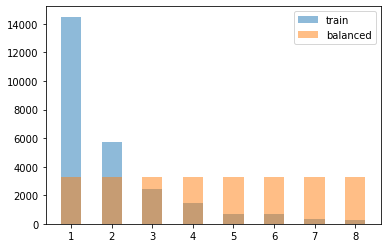

In [13]:
plt.hist(train.toPandas()['SalesQuantity'], bins=[i+0.5 for i in range(0, 9)], rwidth=0.5, alpha=0.5, label='train')
balanced_train = balance(train, 'SalesQuantity')
plt.hist(balanced_train.toPandas()['SalesQuantity'], bins=[i+0.5 for i in range(0, 9)], rwidth=0.5, alpha=0.5, label='balanced')
plt.legend(loc='upper right')
plt.show()

In [14]:
train = balanced_train

In [15]:
transformation_pipeline = Pipeline(stages=get_string_indexers(integrated_sales) + [
    VectorAssembler(inputCols=[
        'SalesPrice', 'DayOfMonth', 'PurchasePrice',
        'VendorNumber_index', 'DayOfWeek_index'], 
                    outputCol='features')
])
transformer = transformation_pipeline.fit(integrated_sales)

In [16]:
# Decision Tree
dtr = DecisionTreeClassifier(maxDepth=10, labelCol='SalesQuantity', featuresCol='features', maxBins=256)
model = dtr.fit(transformer.transform(train))
print_evaluation(model, train, test, 'SalesQuantity', transformer, evaluate_function=evaluate_classification_model)

Training data evaluation metrics:


f1: 0.3219338027301448
accuracy: 0.34083564173591874
Testing data evaluation metrics:


f1: 0.27910822674147456
accuracy: 0.22051048313582497


In [17]:
# Random Forest
rfr = RandomForestClassifier(maxDepth=10, labelCol='SalesQuantity', featuresCol='features', maxBins=256)
model = rfr.fit(transformer.transform(train))
print_evaluation(model, train, test, 'SalesQuantity', transformer, evaluate_function=evaluate_classification_model)

23/10/11 02:39:02 WARN DAGScheduler: Broadcasting large task binary with size 1432.6 KiB
23/10/11 02:39:06 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/10/11 02:39:10 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


Training data evaluation metrics:


23/10/11 02:39:17 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
23/10/11 02:39:19 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


f1: 0.5380134973292834
accuracy: 0.550284702985534
Testing data evaluation metrics:


23/10/11 02:39:21 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/10/11 02:39:22 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


f1: 0.32015204277127285
accuracy: 0.2577939835916135


In [18]:
# Naive Bayes
nb = NaiveBayes(labelCol='SalesQuantity', featuresCol='features')
model = nb.fit(transformer.transform(train))
print_evaluation(model, train, test, 'SalesQuantity', transformer, evaluate_function=evaluate_classification_model)

Training data evaluation metrics:


23/10/11 02:39:25 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/10/11 02:39:25 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


f1: 0.06965653539413372
accuracy: 0.09256694367497692
Testing data evaluation metrics:
f1: 0.13922327723036076
accuracy: 0.09726526891522333


In [19]:
transformation_pipeline = Pipeline(stages=get_string_indexers(integrated_sales) + [
    VectorAssembler(inputCols=[
        'SalesPrice_log10', 'DayOfMonth', 'PurchasePrice_log10',
        'VendorNumber_index', 'DayOfWeek_index'], 
                    outputCol='features')
])
transformer = transformation_pipeline.fit(integrated_sales)

In [20]:
# Decision Tree
dtr = DecisionTreeClassifier(maxDepth=10, labelCol='SalesQuantity', featuresCol='features', maxBins=256)
model = dtr.fit(transformer.transform(train))
print_evaluation(model, train, test, 'SalesQuantity', transformer, evaluate_function=evaluate_classification_model)

Training data evaluation metrics:


f1: 0.3219338027301448
accuracy: 0.34083564173591874
Testing data evaluation metrics:
f1: 0.27910822674147456
accuracy: 0.22051048313582497


In [21]:
# Random Forest
rfr = RandomForestClassifier(maxDepth=10, labelCol='SalesQuantity', featuresCol='features', maxBins=256)
model = rfr.fit(transformer.transform(train))
print_evaluation(model, train, test, 'SalesQuantity', transformer, evaluate_function=evaluate_classification_model)

23/10/11 02:39:54 WARN DAGScheduler: Broadcasting large task binary with size 1432.0 KiB
23/10/11 02:39:57 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/10/11 02:40:02 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


Training data evaluation metrics:


23/10/11 02:40:09 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
23/10/11 02:40:11 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


f1: 0.5380134973292834
accuracy: 0.550284702985534
Testing data evaluation metrics:


23/10/11 02:40:13 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/10/11 02:40:13 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


f1: 0.3203502142355919
accuracy: 0.25797629899726526


### Data Mining - Sales Model

In [8]:
# Random Forest
transformation_pipeline = Pipeline(stages=get_string_indexers(integrated_sales) + [
    VectorAssembler(inputCols=[
        'SalesPrice', 'DayOfMonth', 'PurchasePrice',
        'VendorNumber_index', 'DayOfWeek_index'], 
                    outputCol='features')
])
transformer = transformation_pipeline.fit(integrated_sales)

test_data_size = 1 / (math.sqrt(5) + 1)
print(f'Test data size is {test_data_size}')
train, test = integrated_sales.randomSplit([1-test_data_size, test_data_size], seed=13)
train = balance(train, 'SalesQuantity')

Test data size is 0.3090169943749474


In [10]:
cache = {}
def try_depth(max_depth):
    if cache.get(max_depth) is not None:
        return cache.get(max_depth)
    print('===============================================')
    print(f'Trying maxDepth: {max_depth}')
    rfr = RandomForestClassifier(maxDepth=max_depth, labelCol='SalesQuantity', featuresCol='features', maxBins=256)
    model = rfr.fit(transformer.transform(train))
    print('training:')
    result = model.transform(transformer.transform(train))
    _ = evaluate_classification_model(result, 'SalesQuantity')
    print('testing:')
    result = model.transform(transformer.transform(test))
    cache[max_depth] = evaluate_classification_model(result, 'SalesQuantity')
    return cache[max_depth]

In [11]:
def find_best_max_depth(left, right):
    if left == right:
        return left
    left_metric, right_metric = try_depth(left), try_depth(right)
    if left_metric['accuracy'] < right_metric['accuracy']:
        middle = math.ceil((left + right) / 2)
        return find_best_max_depth(middle, right)
    else:
        middle = math.floor((left + right) / 2)
        return find_best_max_depth(left, middle)

find_best_max_depth(10, 20)

Trying maxDepth: 10


23/10/11 02:26:04 WARN DAGScheduler: Broadcasting large task binary with size 1420.2 KiB
23/10/11 02:26:09 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/10/11 02:26:15 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
23/10/11 02:26:23 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/10/11 02:26:24 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


f1: 0.33074929344408865
accuracy: 0.27016520894071916
Trying maxDepth: 20


23/10/11 02:26:43 WARN DAGScheduler: Broadcasting large task binary with size 1420.2 KiB
23/10/11 02:26:46 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/10/11 02:26:51 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
23/10/11 02:26:57 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
23/10/11 02:27:06 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
23/10/11 02:27:17 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
23/10/11 02:27:25 WARN DAGScheduler: Broadcasting large task binary with size 1195.6 KiB
23/10/11 02:27:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
23/10/11 02:27:40 WARN DAGScheduler: Broadcasting large task binary with size 1370.6 KiB
23/10/11 02:27:48 WARN DAGScheduler: Broadcasting large task binary with size 16.8 MiB
23/10/11 02:28:00 WARN DAGScheduler: Broadcasting large task binary with size 1506.9 KiB
23/10/11 02:28:08 WARN DAGScheduler: Bro

f1: 0.35158873646285366
accuracy: 0.3051506316812439
Trying maxDepth: 15


23/10/11 02:30:18 WARN DAGScheduler: Broadcasting large task binary with size 1420.2 KiB
23/10/11 02:30:21 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/10/11 02:30:25 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
23/10/11 02:30:32 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
23/10/11 02:30:40 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
23/10/11 02:30:51 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
23/10/11 02:30:59 WARN DAGScheduler: Broadcasting large task binary with size 1195.6 KiB
23/10/11 02:31:06 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
23/10/11 02:31:15 WARN DAGScheduler: Broadcasting large task binary with size 1370.6 KiB
23/10/11 02:31:23 WARN DAGScheduler: Broadcasting large task binary with size 16.8 MiB
23/10/11 02:31:34 WARN DAGScheduler: Broadcasting large task binary with size 1506.9 KiB
23/10/11 02:31:43 WARN DAGScheduler: Bro

f1: 0.33863616737072755
accuracy: 0.2844774273345702
Trying maxDepth: 18


23/10/11 02:32:01 WARN DAGScheduler: Broadcasting large task binary with size 1420.2 KiB
23/10/11 02:32:04 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/10/11 02:32:08 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
23/10/11 02:32:14 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
23/10/11 02:32:23 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
23/10/11 02:32:33 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
23/10/11 02:32:43 WARN DAGScheduler: Broadcasting large task binary with size 1195.6 KiB
23/10/11 02:32:50 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
23/10/11 02:32:59 WARN DAGScheduler: Broadcasting large task binary with size 1370.6 KiB
23/10/11 02:33:07 WARN DAGScheduler: Broadcasting large task binary with size 16.8 MiB
23/10/11 02:33:19 WARN DAGScheduler: Broadcasting large task binary with size 1506.9 KiB
23/10/11 02:33:27 WARN DAGScheduler: Bro

f1: 0.3481708910190881
accuracy: 0.29993815708101423
Trying maxDepth: 19


23/10/11 02:34:51 WARN DAGScheduler: Broadcasting large task binary with size 1420.2 KiB
23/10/11 02:34:55 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/10/11 02:34:59 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
23/10/11 02:35:05 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
23/10/11 02:35:14 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
23/10/11 02:35:24 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
23/10/11 02:35:32 WARN DAGScheduler: Broadcasting large task binary with size 1195.6 KiB
23/10/11 02:35:38 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
23/10/11 02:35:48 WARN DAGScheduler: Broadcasting large task binary with size 1370.6 KiB
23/10/11 02:35:56 WARN DAGScheduler: Broadcasting large task binary with size 16.8 MiB
23/10/11 02:36:06 WARN DAGScheduler: Broadcasting large task binary with size 1506.9 KiB
23/10/11 02:36:15 WARN DAGScheduler: Bro

f1: 0.35109653867141505
accuracy: 0.304178814382896


20

In [22]:
# Random Forest
rfr = RandomForestClassifier(maxDepth=20, labelCol='SalesQuantity', featuresCol='features', maxBins=256)
model = rfr.fit(transformer.transform(train))
print_evaluation(model, train, test, 'SalesQuantity', transformer, evaluate_function=evaluate_classification_model)

23/10/11 02:40:28 WARN DAGScheduler: Broadcasting large task binary with size 1432.0 KiB
23/10/11 02:40:31 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/10/11 02:40:36 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
23/10/11 02:40:42 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
23/10/11 02:40:50 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
23/10/11 02:40:56 WARN DAGScheduler: Broadcasting large task binary with size 1002.9 KiB
23/10/11 02:41:01 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB
23/10/11 02:41:09 WARN DAGScheduler: Broadcasting large task binary with size 1204.0 KiB
23/10/11 02:41:15 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
23/10/11 02:41:25 WARN DAGScheduler: Broadcasting large task binary with size 1380.0 KiB
23/10/11 02:41:32 WARN DAGScheduler: Broadcasting large task binary with size 17.0 MiB
23/10/11 02:41:44 WARN DAGScheduler: Br

Training data evaluation metrics:


23/10/11 02:43:42 WARN DAGScheduler: Broadcasting large task binary with size 24.4 MiB
23/10/11 02:43:49 WARN DAGScheduler: Broadcasting large task binary with size 24.4 MiB


f1: 0.9710687689872146
accuracy: 0.9712219144352109
Testing data evaluation metrics:


23/10/11 02:43:55 WARN DAGScheduler: Broadcasting large task binary with size 24.2 MiB
23/10/11 02:43:57 WARN DAGScheduler: Broadcasting large task binary with size 24.2 MiB


f1: 0.3512083659526571
accuracy: 0.3031905195989061


In [24]:
print_feature_importance(model, transformer.transform(train))

+-------------------+----------+
|            feature|importance|
+-------------------+----------+
|PurchasePrice_log10|  0.257652|
|         DayOfMonth|  0.252801|
| VendorNumber_index|  0.191818|
|   SalesPrice_log10|   0.17349|
|    DayOfWeek_index|   0.12424|
+-------------------+----------+



In [6]:
integrated_sales.groupBy('Brand').agg(F.count('Brand').alias('count')).summary().show()

+-------+------------------+------------------+
|summary|             Brand|             count|
+-------+------------------+------------------+
|  count|              3798|              3798|
|   mean|15094.384149552396|10.172985781990521|
| stddev|13184.954924953821| 9.884283717826671|
|    min|               100|                 1|
|    25%|            3919.0|                 3|
|    50%|            8895.0|                 7|
|    75%|           23764.0|                15|
|    max|               999|                52|
+-------+------------------+------------------+

